In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

## All SID

In [5]:
neurons = [100]
rln2 = pd.read_pickle("data/RL_n2_carrabin_feb9_dynamics.pkl")
target_alphas = pd.read_pickle("data/RL_n2_carrabin_feb9_params.pkl")['mu'].to_numpy()
human = pd.read_pickle("data/carrabin.pkl")
rln2['neurons'] = 'RLn2'
human['neurons'] = 'human'
dfs = [human, rln2]
for n in neurons:
    nef = pd.read_pickle(f"data/NEF_RL_carrabin_rln2_{n}neurons_dynamics.pkl")
    nef['neurons'] = str(n)
    dfs.append(nef)
combined = pd.concat(dfs, ignore_index=True)
combined['alpha'] = None

In [6]:
for sid in human['sid'].unique():
    print(sid)
    subdata = combined.query("sid==@sid")
    for i, row in subdata.iterrows():
        mt = row['type']
        sid = row['sid']
        trial = row['trial']
        stage = row['stage']
        response = row['response']
        neurons = row['neurons']
        if stage>1:
            stage_old = stage - 1
            # print(mt, sid, trial, stage, stage_old)
            response_old = subdata.query("type==@mt & neurons==@neurons & trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error)
            combined.at[i, 'alpha'] = alpha
combined.to_pickle("data/alphas_RLn_NEF_RL_neurons.pkl")

1
2
3
4


/tmp/ipykernel_65927/1537021604.py:18: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_65927/1537021604.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.abs(delta / prediction_error)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/tmp/ipykernel_65927/2602738693.py:4: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.kdeplot(combined.query("sid==@sid"), x='alpha', hue='neurons', ax=axes[s],
/tmp/ipykernel_65927/2602738693.py:4: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.kdeplot(combined.query("sid==@sid"), x='alpha', hue='neurons', ax=axes[s],
/tmp/ipykernel_65927/2602738693.py:4: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.kdeplot(combined.query("sid==@sid"), x='alpha', hue='neurons', ax=axes[s],
/tmp/ipykernel_65927/2602738693.py:4: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.kdeplot(combined.query("sid==@sid"), x='alpha', hue='neurons', ax=axes[s],
/tmp/ipykernel_65927/2602738693.py:4: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.kdeplot(co

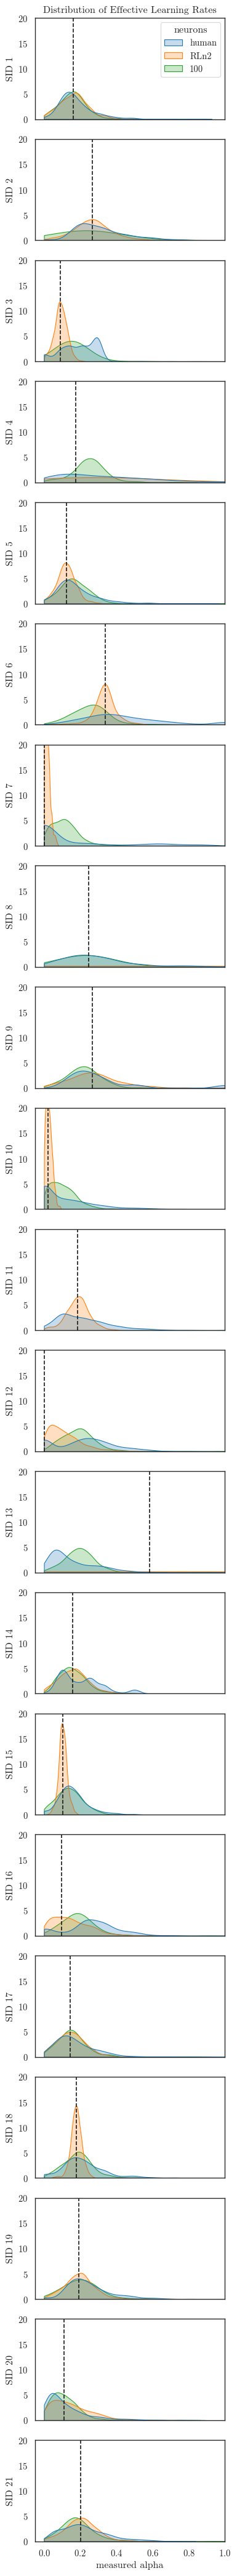

In [7]:
sids = human['sid'].unique()
fig, axes = plt.subplots(nrows=len(sids), ncols=1, figsize=(4, 2*len(sids)), sharex=True)
for s, sid in enumerate(sids):
    sns.kdeplot(combined.query("sid==@sid"), x='alpha', hue='neurons', ax=axes[s],
                clip=[0, 1], palette=palette[:3], fill=True, common_norm=False)
    axes[s].set(ylabel=f"SID {sid}", ylim=[0, 20])
    axes[s].axvline(target_alphas[s], color='k', ls="--")
    if s>0: axes[s].get_legend().remove()
axes[0].set(title='Distribution of Effective Learning Rates')
axes[-1].set(xlabel='measured alpha', xlim=[-0.05, 1])
plt.tight_layout()
fig.savefig("plots/alpha_distributions_all_sids.jpg", dpi=600)

## One SID

In [9]:
def plotz(sid):
    filename = f"RL_n2_carrabin_{sid}"
    rln2 = pd.read_pickle(f"data/{filename}_dynamics.pkl")
    target_alpha = pd.read_pickle(f"data/{filename}_params.pkl")['mu'].to_numpy()
    human = pd.read_pickle("data/carrabin.pkl").query("sid==@sid")
    rln2['neurons'] = 'RLn2'
    human['neurons'] = 'human'
    dfs = [human, rln2]
    # for n in neurons:
    #     nef = pd.read_pickle(f"data/NEF_RL_carrabin_rln2_{n}neurons_dynamics.pkl")
    #     nef['neurons'] = str(n)
    #     dfs.append(nef)
    combined = pd.concat(dfs, ignore_index=True)
    combined['alpha'] = None
    for i, row in combined.iterrows():
        mt = row['type']
        trial = row['trial']
        stage = row['stage']
        response = row['response']
        neurons = row['neurons']
        if stage>1:
            stage_old = stage - 1
            response_old = combined.query("type==@mt & neurons==@neurons & trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error)
            combined.at[i, 'alpha'] = alpha

    g = sns.FacetGrid(combined, row="qid", hue="neurons")
    # g.map_dataframe(sns.histplot, x="response", fill=True, common_norm=False, bins=np.linspace(-1,1,20))
    g.map_dataframe(sns.kdeplot, x="response", fill=True, common_norm=False)
    g.set(ylim=(0, 30))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2), sharex=True)
    sns.kdeplot(combined, x='alpha', hue='neurons', ax=ax, clip=[0, 1], palette=palette[:3], fill=True, common_norm=False)
    ax.set(ylabel=f"SID {sid}", ylim=[0, 20])
    ax.axvline(target_alpha, color='k', ls="--")
    ax.set(title='Distribution of Effective Learning Rates')
    ax.set(xlabel='measured alpha', xlim=[-0.05, 1])
    plt.tight_layout()
    plt.show()

/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disa

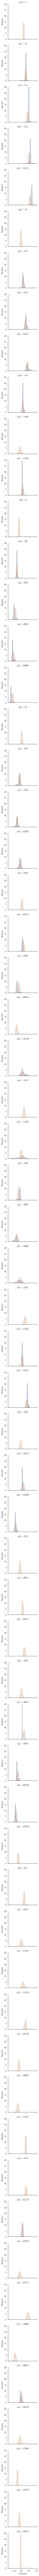

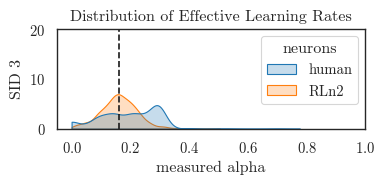

In [10]:
plotz(3)